In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
#%config InlineBackend.figure_formats = ['svg']

## Plots of non-interacting Green function in Matsubara time

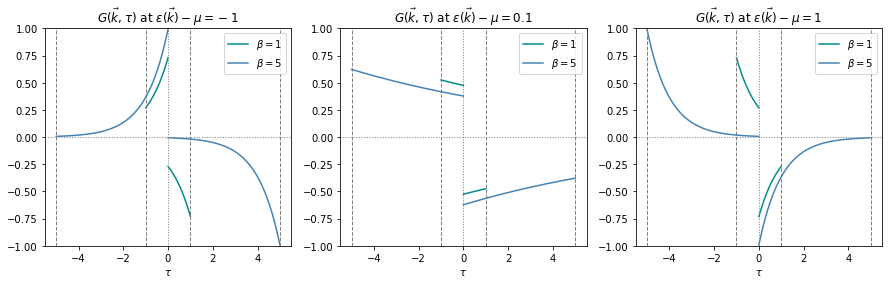

In [66]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

beta=10
def f (e,beta):
    return 1/(1+np.exp(beta*e))
def Gtau (tau, ek, beta):
    return -np.exp(-ek*tau) * ( (1-f(ek,beta))*np.heaviside(tau,1) - f(ek,beta)*np.heaviside(-tau,1) )
#def Gtau (tau, ek, beta):
#    return -np.exp(-ek*(tau-beta)) * f(ek,beta)

for ek,ax in zip([-1,0.1,1],axes):
    for beta,color in zip([1,5],['darkcyan','steelblue']):
        tau = np.linspace(-beta,-1e-10,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color, label=r"$\beta={}$".format(beta))
        tau = np.linspace(1e-10,beta,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color)
        ax.axvline(x=-beta, linestyle='--', lw=1, color='gray')
        ax.axvline(x=+beta, linestyle='--', lw=1, color='gray')
    ax.axvline(x=0, linestyle='dotted', lw=1, color='gray')
    ax.axhline(y=0, linestyle='dotted', lw=1, color='gray')
    ax.set_title(r"$G(\vec{{k}},\tau)$ at $\epsilon(\vec{{k}})-\mu={}$".format(ek))
    ax.set_ylim((-1,1))
    ax.set_xlabel(r"$\tau$")
    ax.legend()
plt.savefig("green-func-non-interacting.pdf", bbox_inches="tight")

# Unit tests for Green functions

In [134]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],float]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time (β:float, Giωn:np.array) -> Callable[[float],float]:
    # Giωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    n = np.arange(-len(Giωn)//2, len(Giωn)//2)
    f = lambda τ: 1/β * np.sum( np.exp(-1j*ωn(β,n)*τ) * Giωn )
    return np.vectorize(f)

# if more usefull :
def greenmatsubara_freq_to_time_half (β:float, Giωn_half:np.array) -> Callable[[float],float]:
    # Giωn_half should have an size N, corresponding to n's in [0,N[
    n = np.arange(0, len(Giωn_half))
    f = lambda τ: 2/β * np.sum( np.real( np.exp(-1j*ωn(β,n)*τ) * Giωn_half ) )
    return np.vectorize(f)

Text(0, 0.5, '$G(\\tau)$')

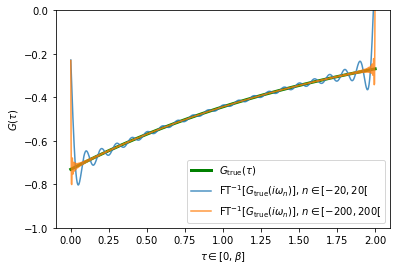

In [147]:
def test_Giωn_1 (β, n, ξ):
    iωn = 1j*ωn(β,n)
    return 1 / ( iωn - ξ )

def test_Gτ_1 (β, τ, ξ):
    return -np.exp(ξ*(β-τ)) / ( np.exp(β*ξ) + 1 )

β = 2
τ = np.linspace(0,β,1000)
dτ = τ[1] - τ[0]
ξ = 0.5

plt.plot( τ, test_Gτ_1(β,τ,ξ), label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [20,200]:
    n = np.arange(-ncut,ncut)
    test_Gτ_1_tr = greenmatsubara_freq_to_time(β, Giωn=test_Giωn_1(β,n,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut), alpha=0.8)

plt.legend();
plt.xlabel(r"$\tau \in [0,\beta]$")
plt.ylabel(r"$G(\tau)$")
#plt.savefig("green-tau-ringing.pdf", bbox_inches='tight')

In [57]:
np.linalg.norm(np.imag(test_Gτ_1_tr(τ)), ord=np.inf)

0.04179851889130457

Ok, this is bad. We need to singularize the $1/\mathrm{i}\omega_n$ term.

In [70]:
def greenmatsubara_freq_to_time_sing (β:float, Giωn_sing:np.array) -> Callable[[float],float]:
    # Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2)
    f = lambda τ: 1/β * np.sum( np.exp(-1j*ωn(β,n)*τ) * Giωn_sing ) - 1/2
    return np.vectorize(f)

# if more usefull :
def greenmatsubara_freq_to_time_singhalf (β:float, Giωn_singhalf:np.array) -> Callable[[float],float]:
    # Giωn_singhalf should have an size N, corresponding to n's in [0,N[
    n = np.arange(0, len(Giωn_singhalf))
    f = lambda τ: 2/β * np.sum( np.real( np.exp(-1j*ωn(β,n)*τ) * Giωn_singhalf ) ) -1/2
    return np.vectorize(f)

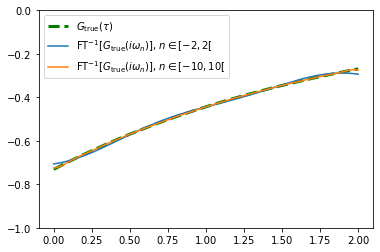

In [72]:
def test_Giωn_1_sing (β, n, ξ):
    iωn = 1j*ωn(β,n)
    return 1/( iωn - ξ ) - 1/iωn

plt.plot( τ, test_Gτ_1(β,τ,ξ), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [2, 10]:
    n = np.arange(-ncut,ncut)
    test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, test_Giωn_1_sing(β,n,ξ))
    # or with only positive frequencies :
    # n = np.arange(0,ncut)
    # test_Gτ_1_tr = greenmatsubara_freq_to_time_singhalf(β, test_Giωn_1_sing(β,n,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut))

plt.legend();
#plt.savefig("green-tau-singularized.pdf", bbox_inches='tight')

Muuuuuuuuuuch better. Even $n=2$ works ok !

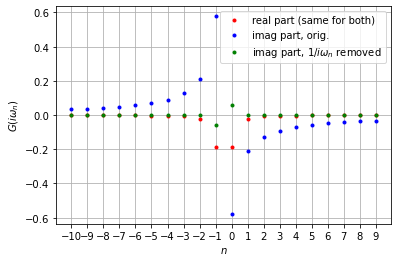

In [84]:
n = np.arange(-10,10)
plt.plot(n, np.real(test_Giωn_1(β,n,ξ)), '.', label="real part (same for both)", color='red')
plt.plot(n, np.imag(test_Giωn_1(β,n,ξ)), '.', label="imag part, orig.", color='blue')
plt.plot(n, np.imag(test_Giωn_1_sing(β,n,ξ)), '.', label=r"imag part, $1/i\omega_n$ removed", color='green')
plt.legend()
plt.xlabel("$n$")
plt.xticks(n)
plt.ylabel(r"$G(i\omega_n)$")
plt.grid();

Now let's check the other way around.

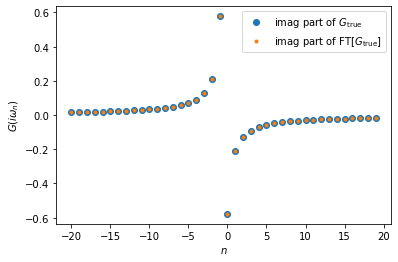

In [162]:
n = np.arange(-20,20)
test_Giωn_1_tr = greenmatsubara_time_to_freq(β, dτ, test_Gτ_1(β,τ,ξ))
plt.plot(n, np.imag(test_Giωn_1(β,n,ξ)), 'o', label="imag part of $G_\operatorname{true}$")
plt.plot(n, np.imag(test_Giωn_1_tr(n)), '.', label=r"imag part of $\operatorname{FT}[G_\operatorname{true}]$")
plt.legend()
plt.xlabel("$n$")
plt.ylabel(r"$G(i\omega_n)$");

### Atomic limit

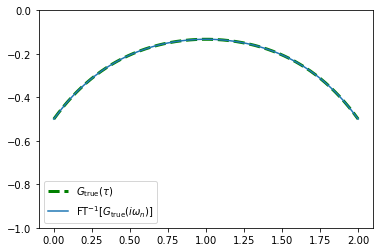

In [181]:
def Giωn_at (β, n, U):
    iωn = 1j*ωn(β,n)
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Giωn_at_sing (β, n, U):
    iωn = 1j*ωn(β,n)
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 ) - 1/iωn

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

U = 4

plt.plot( τ, Gτ_at(β,τ,U), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

n = np.arange(-10,10)
Gτ_at_tr = greenmatsubara_freq_to_time_sing(β, Giωn_at_sing(β,n,U))
plt.plot(τ,Gτ_at_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$")

plt.legend();

Self energy $\Sigma = G_0^{-1} - G^{-1}$ in $\mathrm{i}\omega_n$ :

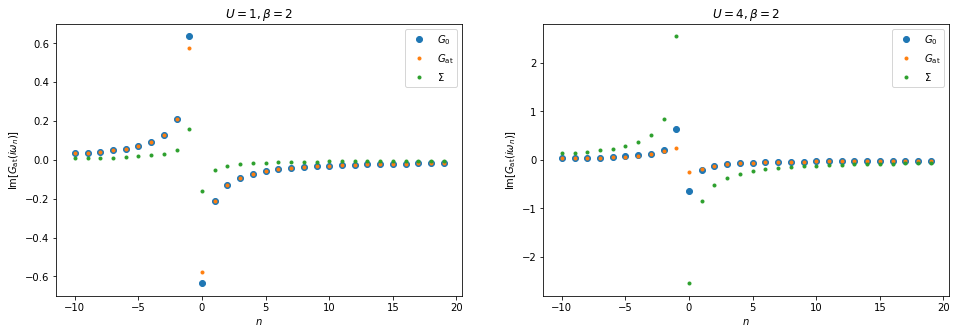

In [185]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,5))
n = np.arange(-10,20)
iωn = 1j*ωn(β,n)
for U,ax in zip([1, 4], [ax1,ax2]):
    G0 = 1/iωn
    Gat = 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )
    SelfEn = 1/G0 - 1/Gat
    ax.plot(n, np.imag(G0), 'o', label="$G_0$")
    ax.plot(n, np.imag(Gat), '.', label=r"$G_\operatorname{at}$")
    ax.plot(n, np.imag(SelfEn), '.', label=r"$\Sigma$")
    ax.legend()
    ax.set_xlabel("$n$")
    ax.set_ylabel(r"$\operatorname{Im}[ G_\operatorname{at}(i\omega_n) ]$");
    ax.set_title(r"$U={}, \beta=2$".format(U))